# Big Data Hypothesis 3 : the genre influences the ratings 

Loading dataset and remove lines without genres:

In [1]:
import findspark
# Locate the Spark installation 
findspark.init()

import pyspark
from pyspark import StorageLevel
from pyspark.sql.functions import regexp_replace
from pyspark.sql import *

spark = SparkSession.builder\
        .appName("H3")\
        .master("local[*]")\
        .config("spark.driver.memory", "4g")\
        .config("spark.executor.memory", "5g")\
        .config("spark.storage.memoryFraction", "0.5")\
        .config("spark.shuffle.memoryFraction", "0.5")\
        .config("spark.driver.maxResultSize", "0")\
        .getOrCreate()

23/06/27 23:41:04 WARN Utils: Your hostname, DSaDBA resolves to a loopback address: 127.0.1.1; using 10.0.2.15 instead (on interface enp0s3)
23/06/27 23:41:04 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/06/27 23:41:04 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [9]:
from pyspark import StorageLevel
from pyspark.sql.functions import (regexp_replace, col, lit, length, expr, split, explode, mean,
                                   when, count, array_remove, collect_list)
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f_oneway

In [3]:
from pyspark.sql.types import StructType, StructField, ArrayType, StringType, LongType

# Define the schema
schema = StructType([
    StructField('movie', StringType(), True),
    StructField('rating', LongType(), True),
    StructField('genre', StringType(), True),
    StructField('review_date', StringType(),True),
    StructField('review_detail', StringType(), True),
    StructField('review_id', StringType(), True),
    StructField('review_summary', StringType(), True),
    StructField('reviewer', StringType(), True),
    StructField('spoiler_tag', LongType(), True),
    StructField('helpful_upvotes', LongType(), True),
    StructField('helpful_total', LongType(), True)])

In [4]:
# Limit the size of the data to around 1GB due to working on a single machine
lim = 1000000


# Read the files to filter from the HDFS and display the table
columns = ['movie', 'rating', 'genre']
base_df = spark.read.csv('hdfs://localhost:54310/user/data/filtered', schema=schema, sep="\t", mode="DROPMALFORMED").select(columns)
df = base_df.sample(withReplacement=False, fraction=lim/base_df.count())
#Preparing Data To Ivestigate The Hypothesis
df.limit(5).toPandas()

,movie,rating,genre
0,Satanic (2016),4,-
1,Satanic (2016),1,-
2,Satanic (2016),1,-
3,Satanic (2016),10,-
4,Satanic (2016),1,-


+------+-------+
|rating|  genre|
+------+-------+
|     6|  Drama|
|     6|Musical|
|    10|  Drama|
|    10|Musical|
|     8| Comedy|
|     8|  Drama|
|     8|Romance|
|  null| Comedy|
|  null|  Drama|
|  null|Romance|
|     9| Comedy|
|     9|  Drama|
|     9|Romance|
|    10| Comedy|
|    10|  Drama|
|    10|Romance|
|     6| Comedy|
|     6|  Drama|
|     6|Romance|
|    10| Comedy|
+------+-------+
only showing top 20 rows



['Crime', 'Romance', 'Thriller', 'Adventure', 'Drama', 'War', 'Documentary', 'Fantasy', 'Mystery', 'Musical', 'Animation', 'IMAX', 'Horror', 'Western', 'Comedy', 'Children', 'Action']


+-----------+------------------+
|      genre|        avg_rating|
+-----------+------------------+
|      Crime| 7.008521846916641|
|    Romance| 7.091048986919723|
|   Thriller| 6.614992513300838|
|  Adventure|6.7017440836220565|
|      Drama| 7.161871497035172|
|        War| 7.210330684439887|
|Documentary| 7.445783132530121|
|    Fantasy| 6.684526436578692|
|    Mystery| 6.892853438439996|
|    Musical|  7.47201182338814|
|  Animation| 7.557563959955506|
|       IMAX| 6.505897219882056|
|     Horror| 6.246445811016333|
|    Western| 7.338804220398593|
|     Comedy| 6.914415403763087|
|   Children|7.3903332112779205|
|     Action|  6.55267410831736|
+-----------+------------------+



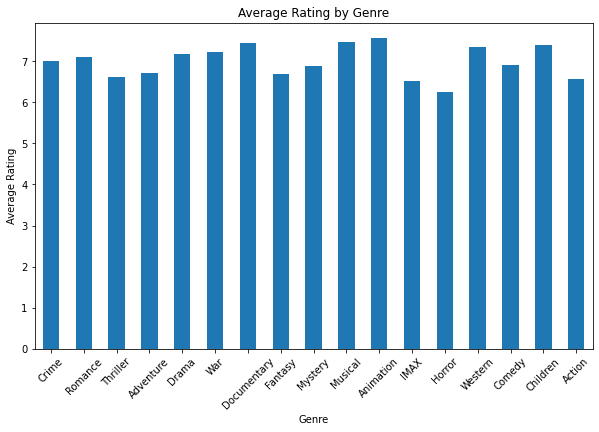

In [7]:
# Preparing Data to Investigate the Hypothesis
df = df.filter(~col('genre').contains('-'))
df = df.filter(~col('genre').contains('no genres listed'))

# Split the genre field by the "|" character
split_genres = split(df['genre'], '\|')

# Add the split genre columns to the original DataFrame
df = df.withColumn('genres_list', array_remove(split_genres, ''))

# Convert the genre-specific columns to a single 'genre' column using explode
df = df.select(col('rating'), explode(col('genres_list')).alias('genre'))

# Print dataset with rating for each review and genre
df.show()

# Get unique values in the column
unique_values = df.select('genre').distinct().collect()
unique_values = [row['genre'] for row in unique_values]

# Print the unique values
print(unique_values)

# Calculate the mean rating for each genre
mean_ratings = df.groupBy('genre').agg(mean('rating').alias('avg_rating'))

# Print the dataset with genre and average rating columns
mean_ratings.show()

# Create a bar plot
mean_ratings_pd = mean_ratings.toPandas()
mean_ratings_pd.set_index('genre', inplace=True)

plt.figure(figsize=(10, 6))
mean_ratings_pd['avg_rating'].plot(kind='bar')
plt.xlabel('Genre')
plt.ylabel('Average Rating')
plt.title('Average Rating by Genre')
plt.xticks(rotation=45)
plt.show()

## ANOVA TEST

In [10]:
# Group the ratings by genre
grouped_data = df.groupBy('genre').agg(collect_list('rating').alias('ratings'))

# Perform ANOVA
ratings_by_genre = [row['ratings'] for row in grouped_data.collect()]
statistic, p_value = f_oneway(*ratings_by_genre)

# Print the results
print("ANOVA results:")
print("F-statistic:", statistic)
print("p-value:", p_value)

ANOVA results:
F-statistic: 204.63514069102627
p-value: 0.0


In [11]:
# Stop Spark
spark.stop()